In [224]:
from collections import namedtuple
import random
from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from brokenaxes import brokenaxes
from meth5 import MetH5File

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from benchmark_pycometh.config import module_config
from nanoepitools.reference_cpgs import ReferenceCpGs

In [2]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})

In [3]:
reference_cpgs = ReferenceCpGs("/home/r933r/data/resource/human/hg19/hg19_no_chr.fa")

In [4]:
def convert_to_cg_index(segments):
    start = 0
    cpg_indices = []
    last_end_coord = 0
    for row in segments.itertuples():
        gap_cpgs = reference_cpgs.get_CGs(row.chrom, last_end_coord, row.start-1)
        cpgs = reference_cpgs.get_CGs(row.chrom, row.start, row.end)
        last_end_coord = row.end
        start = start + len(gap_cpgs)
        end = start + len(cpgs)
        cpg_indices.append((start, end))
        start = end
    segments["real_start"] = segments["start"]
    segments["real_end"] = segments["end"]
    segments["start"] = [i[0] for i in cpg_indices]
    segments["end"] = [i[1] for i in cpg_indices]

In [5]:
ground_truth_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/wgbs/merged/changepoints.txt"
gt = pd.read_csv(ground_truth_file, sep="\t", names=["chrom", "start", "end", "segment_type", "theta"], dtype={"chrom":str})
gt_only_diffmet = gt.loc[gt["theta"]!=0].copy()



In [6]:
methylkit_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methylkit/methylkit_segmentation.bed"
methylkit_seg = pd.read_csv(methylkit_seg_file, sep="\t", skiprows=1, usecols=[0,1,2], names=["chrom", "start", "end"], dtype={"chrom":str})


In [7]:
methcp_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methcp/methcp_segments.bed"
methcp_seg = pd.read_csv(methcp_seg_file, sep="\t", usecols=[0,1,2], names=["chrom", "start", "end"], dtype={"chrom":str})

In [8]:
def load_pycometh(file, merge_window="no"):
    pm = pd.read_csv(file, sep="\t", usecols=[0,1,2,4], names=["chrom", "start", "end", "type"], dtype={"chrom":str})
    if merge_window == "no":
        return pm
    rows = []
    start = 0
    for row in pm.itertuples():
        if row.type == "window_start" and start != 0:
            rows.append({"chrom": row.chrom, "end": row.end, "start": start})
        elif row.type == "window_end":
            start = row.start
        else:
            rows.append({"chrom": row.chrom, "end": row.end, "start": row.start})
    return pd.DataFrame(rows)

pycometh_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/segmentation/segments_2.tsv"
pycometh_seg = load_pycometh(pycometh_seg_file)

pycometh_8_lw_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/segmentation/segments_8_lw_2.tsv"
pycometh_seg_course = load_pycometh(pycometh_8_lw_seg_file)

In [217]:
pycometh_seg_merged = load_pycometh(pycometh_8_lw_seg_file, merge_window="yes")

In [218]:
class SegmentsComparer:
    def __init__(self, gt_segments, predicted_segments):
        self.gt_segments = gt_segments
        self.predicted_segments = predicted_segments

    def compute_dist_from_a_to_b(self, a, b):
        total = len(a)
        for seg in tqdm.tqdm(a.itertuples(), total=total, disable=True):
            d = (b["start"] - seg.start).abs()
            nearest_dist = d.min()
            d = (b["end"] - seg.start).abs()
            nearest_dist = min(nearest_dist, d.min())
            d = (b["start"] - seg.end).abs()
            nearest_dist = min(nearest_dist, d.min())
            d = (b["end"] - seg.end).abs()
            nearest_dist = min(nearest_dist, d.min())
            yield nearest_dist

    def compute_gt_dist_to_predicted(self, segments):
        return self.compute_dist_from_a_to_b(self.gt_segments, segments)

    def compute_gt_dist_to_all_predicted(self):
        dists = {}
        for tool in self.predicted_segments:
            dists[tool] = np.array(list(self.compute_gt_dist_to_predicted(self.predicted_segments[tool])))
        return dists

    def compute_predicted_dist_to_gt(self, segments):
        return self.compute_dist_from_a_to_b(segments, self.gt_segments)

    def compute_predicted_dist_to_all_gt(self):
        dists = {}
        for tool in self.predicted_segments:
            dists[tool] = np.array(list(self.compute_predicted_dist_to_gt(self.predicted_segments[tool])))
        return dists

    def get_segments_around(self, pos, gt = None):
        if gt is None:
            gt = self.gt_segments
        last_seg = None
        seg_it = gt.itertuples()
        try:
            while True:
                seg = next(seg_it)
                if seg.start <= pos <= seg.end:
                    try:
                        next_seg = next(seg_it)
                    except StopIteration:
                        next_seg = None
                    return last_seg, seg, next_seg
                elif last_seg is not None:
                    if last_seg.end <= pos <= seg.start:
                        return last_seg, None, seg
                if pos < seg.start:
                    return None, None, None
                last_seg = seg
        except StopIteration:
            return None, None, None

    def find_separated_segments(self, cp, gt=None, max_dist_rel=0.05):
        """If the given changepoint marks a ground truth changepoint, this function will return a tuple
        with the two segments it separates"""
        last_seg, in_seg, next_seg = self.get_segments_around(cp, gt=gt)
        if in_seg is None and last_seg is not None and next_seg is not None:
            # If the cp is not in a sgement, it is between segments, which is a perfect changepoint
            return last_seg, next_seg
        elif in_seg is not None:
            if in_seg.end - cp < cp - in_seg.start:
                dist = in_seg.end - cp
                neighbor_segs = in_seg, next_seg
            else:
                dist = cp - in_seg.start
                neighbor_segs = last_seg, in_seg

            max_dist = (in_seg.end - in_seg.start) * max_dist_rel
            if dist <= max_dist:
                return neighbor_segs
        return None, None

    def classify_changepoint(self, cp, max_dist_rel=0.05):
        seg_a, seg_b = self.find_separated_segments(cp)
        if seg_a is None or seg_b is None:
            return 0, "unsupported"
        if seg_a.theta != 0 or seg_b.theta != 0:
            return 2, "diff_seg_cp"
        else:
            return 1, "true_cp"

    def classify_all_segments(self, tool):
        segments = self.predicted_segments[tool]
        classes = {"unsupported": 0, "diff_seg_cp": 0, "true_cp": 0}
        with tqdm.tqdm(total=len(self.predicted_segments[tool])) as pbar:
            cp_class = (0, "unsupported")
            for seg in segments.itertuples():
                # We only count one (the better) class for a pair of segment end and next segment start
                cp_class = max(cp_class, self.classify_changepoint(seg.start))
                classes[cp_class[1]] += 1
                cp_class = self.classify_changepoint(seg.end)
                pbar.update(1)
            classes[cp_class[1]] += 1
        return classes

    def count_segments_identified(self, tool):
        gt = self.gt_segments.copy()
        gt["found_right"] = False
        gt["found_left"] = False
        cps_unused = []
        with tqdm.tqdm(total=self.predicted_segments[tool].shape[0]) as pbar:
            for segment in self.predicted_segments[tool].itertuples():
                for pos in segment.start, segment.end:
                    seg_a, seg_b = self.find_separated_segments(pos, gt=gt)
                    if seg_a is None or seg_b is None:
                        cps_unused.append(pos)
                        continue
                    if gt.loc[seg_a.Index,"found_left"]:
                        gt = gt.drop(seg_a.Index)
                    else:
                        gt.loc[seg_a.Index, "found_right"] = True
                    if gt.loc[seg_b.Index, "found_right"]:
                        gt = gt.drop(seg_b.Index)
                    else:
                        gt.loc[seg_b.Index,"found_left"] = True
                pbar.update(1)
        return gt, cps_unused



In [145]:
def permute_segments(original_segments):
    segment_lengths = original_segments.apply(lambda x: x["end"] - x["start"], axis=1).tolist()
    ends = np.array([0] + original_segments["end"].tolist())[:-1]
    starts = np.array(original_segments["start"])
    gaps = starts - ends
    offset = gaps[0]
    gaps = gaps[1:]
    random.shuffle(segment_lengths)
    random.shuffle(gaps)
    gaps = iter(gaps)
    region = namedtuple("region", ["start", "end"])

    ret = []
    for l in segment_lengths:
        ret.append(region(offset, offset + l))
        try:
            offset += next(gaps) + l
        except StopIteration:
            continue
    return pd.DataFrame({"chrom":"1", "start": [r.start for r in ret], "end": [r.end for r in ret]})

In [254]:
sc = SegmentsComparer(gt_segments=gt, predicted_segments={"PycoMeth": pycometh_seg,
                                                          "PycoMeth (random)": permute_segments(pycometh_seg),
                                                          "PycoMeth coarse": pycometh_seg_course,
                                                          "PycoMeth coarse (random)": permute_segments(pycometh_seg_course),
                                                          "MethCP": methcp_seg,
                                                          "MethCP (random)": permute_segments(methcp_seg),
                                                          "MethylKit": methylkit_seg,
                                                          "MethylKit (random)": permute_segments(methylkit_seg)})

In [272]:
sc.gt_segments = gt
all_dists_from_gt = sc.compute_gt_dist_to_all_predicted()
all_dists_from_pred = sc.compute_predicted_dist_to_all_gt()

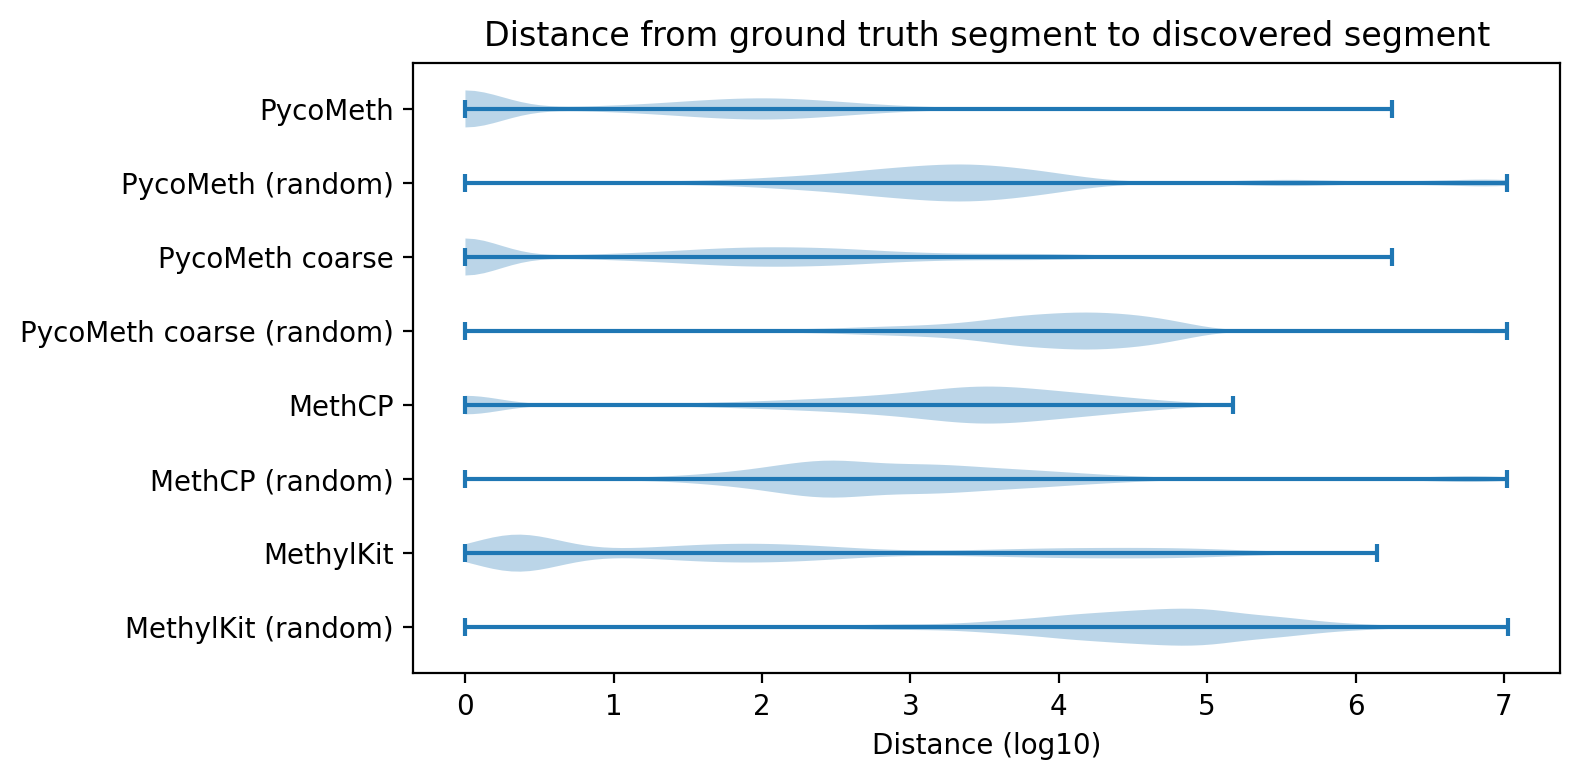

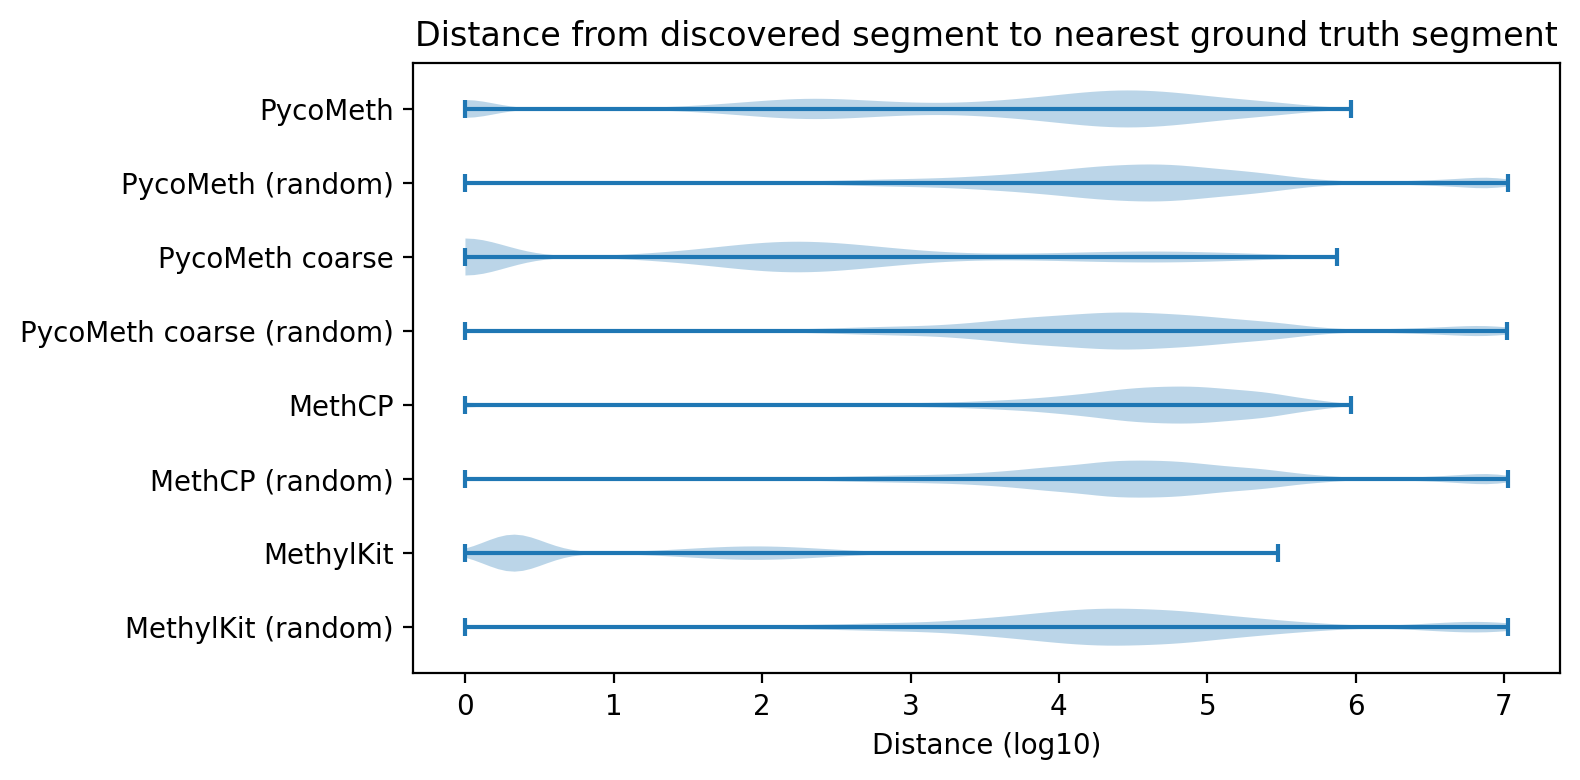

In [273]:
pa.figure(figsize=(8,4))
tools = list(all_dists_from_gt.keys())[::-1]
x = np.arange(len(tools))
plt.violinplot([np.log10(all_dists_from_gt[tool]+1) for tool in tools], positions=x, vert=False)
plt.yticks(x, tools)
plt.title("Distance from ground truth segment to discovered segment")
plt.xlabel("Distance (log10)")
pa.saveandshow("dist_disc_to_gt")

pa.figure(figsize=(8,4))
plt.violinplot([np.log10(all_dists_from_pred[tool]+1) for tool in tools], positions=x, vert=False)
plt.yticks(x, tools)
plt.title("Distance from discovered segment to nearest ground truth segment")
plt.xlabel("Distance (log10)")
pa.saveandshow("dist_gt_to_disc")

In [274]:
sc.gt_segments = gt_only_diffmet
all_dists_from_gt_gtonly = sc.compute_gt_dist_to_all_predicted()
all_dists_from_pred_gtonly = sc.compute_predicted_dist_to_all_gt()

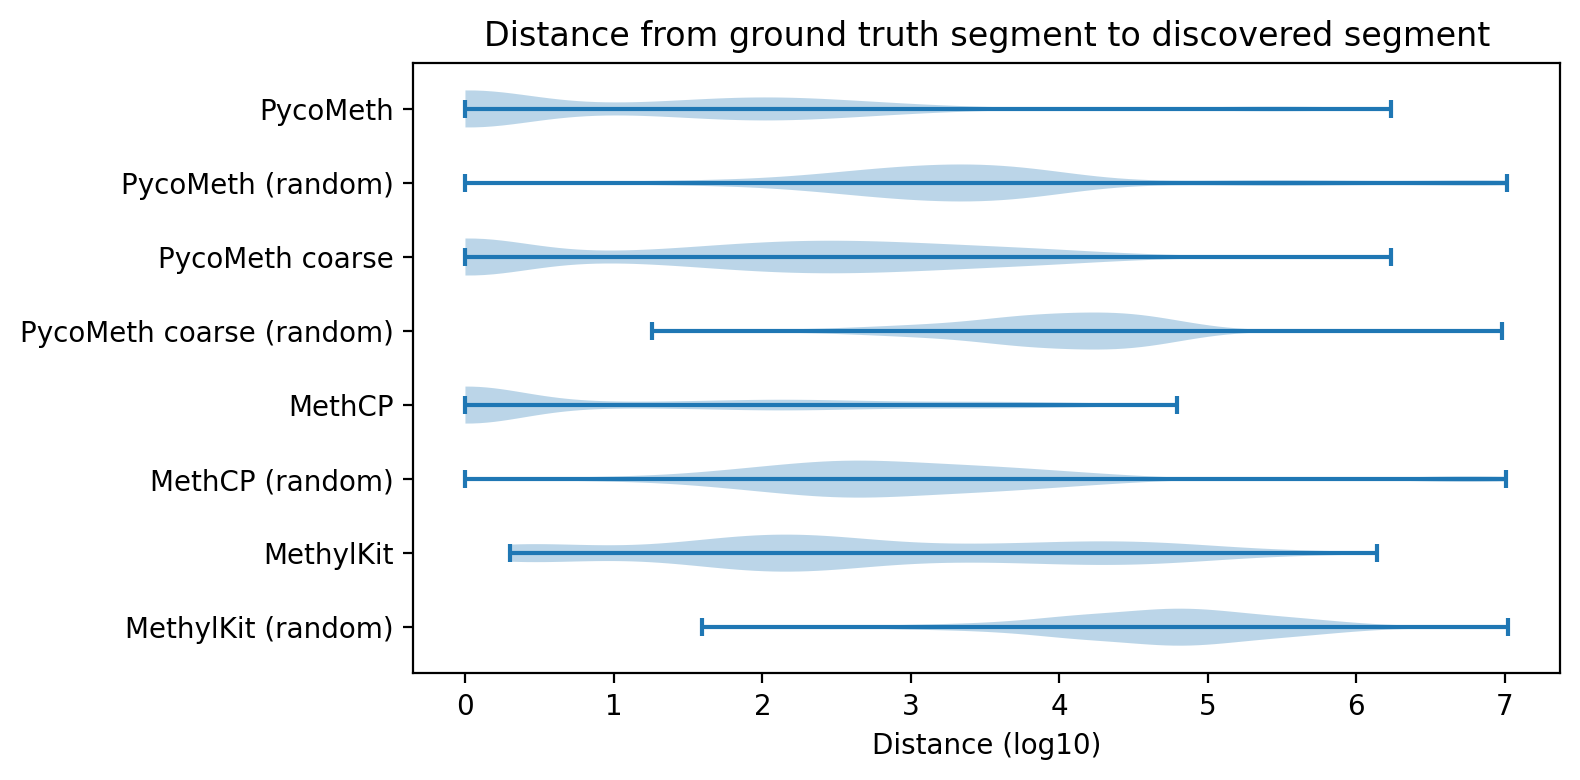

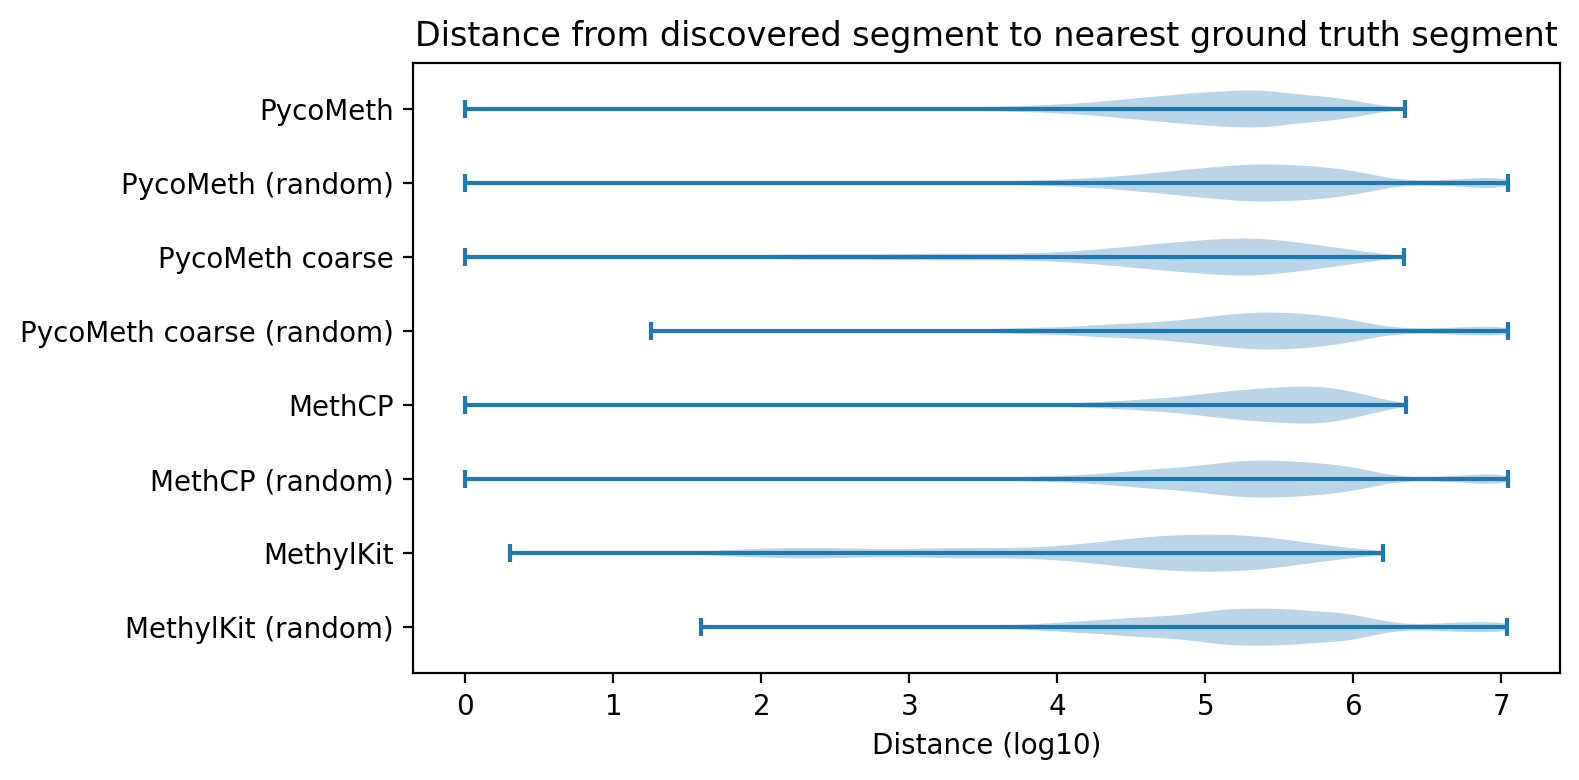

In [275]:
pa.figure(figsize=(8,4))
tools = list(all_dists_from_gt.keys())[::-1]
x = np.arange(len(tools))
plt.violinplot([np.log10(all_dists_from_gt_gtonly[tool]+1) for tool in tools], positions=x, vert=False)
plt.yticks(x, tools)
plt.title("Distance from ground truth segment to discovered segment")
plt.xlabel("Distance (log10)")
pa.saveandshow("dist_disc_to_gt_onlygt")

pa.figure(figsize=(8,4))
plt.violinplot([np.log10(all_dists_from_pred_gtonly[tool]+1) for tool in tools], positions=x, vert=False)
plt.yticks(x, tools)
plt.title("Distance from discovered segment to nearest ground truth segment")
plt.xlabel("Distance (log10)")
pa.saveandshow("dist_gt_to_disc_onlygt")

In [31]:
from nanoepitools.plotting.plot_methylation_profile import plot_met_profile_from_matrix, plot_met_profile
from meth5 import MetH5File
simulated_m5 = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/diffmet_merged.m5"
simulated_m5 = MetH5File(simulated_m5, "r")

def plot_methylation_all_segments(chrom, start, end, highlights=[]):
    matrix = simulated_m5[chrom].get_values_in_range(start, end).to_sparse_methylation_matrix(read_groups_key="sample")
    fig, ax = pa.subplots(5,2, figsize=(20,12))
    for i, tool in enumerate(["GT", "PycoMeth", "PycoMeth coarse", "MethCP", "MethylKit"]):
        if tool == "GT":
            seg = gt
        else:
            seg = sc.predicted_segments[tool]
        plt.sca(ax[i,0])
        plt.title(tool)
        plot_met_profile_from_matrix(matrix, aggregate_samples=True)
        plt.vlines(seg.loc[(seg["start"] > start)&(seg["start"] < end)]["start"], plt.ylim()[0], plt.ylim()[1])

        plt.sca(ax[i,1])
        if tool != "GT":
            tool = f"{tool} (random)"
            seg = sc.predicted_segments[tool]
            plt.title(tool)
            plot_met_profile_from_matrix(matrix, aggregate_samples=True, highlights=highlights, highlights_in_genomic_space=True, highlights_color=[217, 217, 87])
            plt.vlines(seg.loc[(seg["start"] > start)&(seg["start"] < end)]["start"], plt.ylim()[0], plt.ylim()[1])
    plt.show()

9968 522445


TypeError: plot_met_profile() got an unexpected keyword argument 'highlights_color'

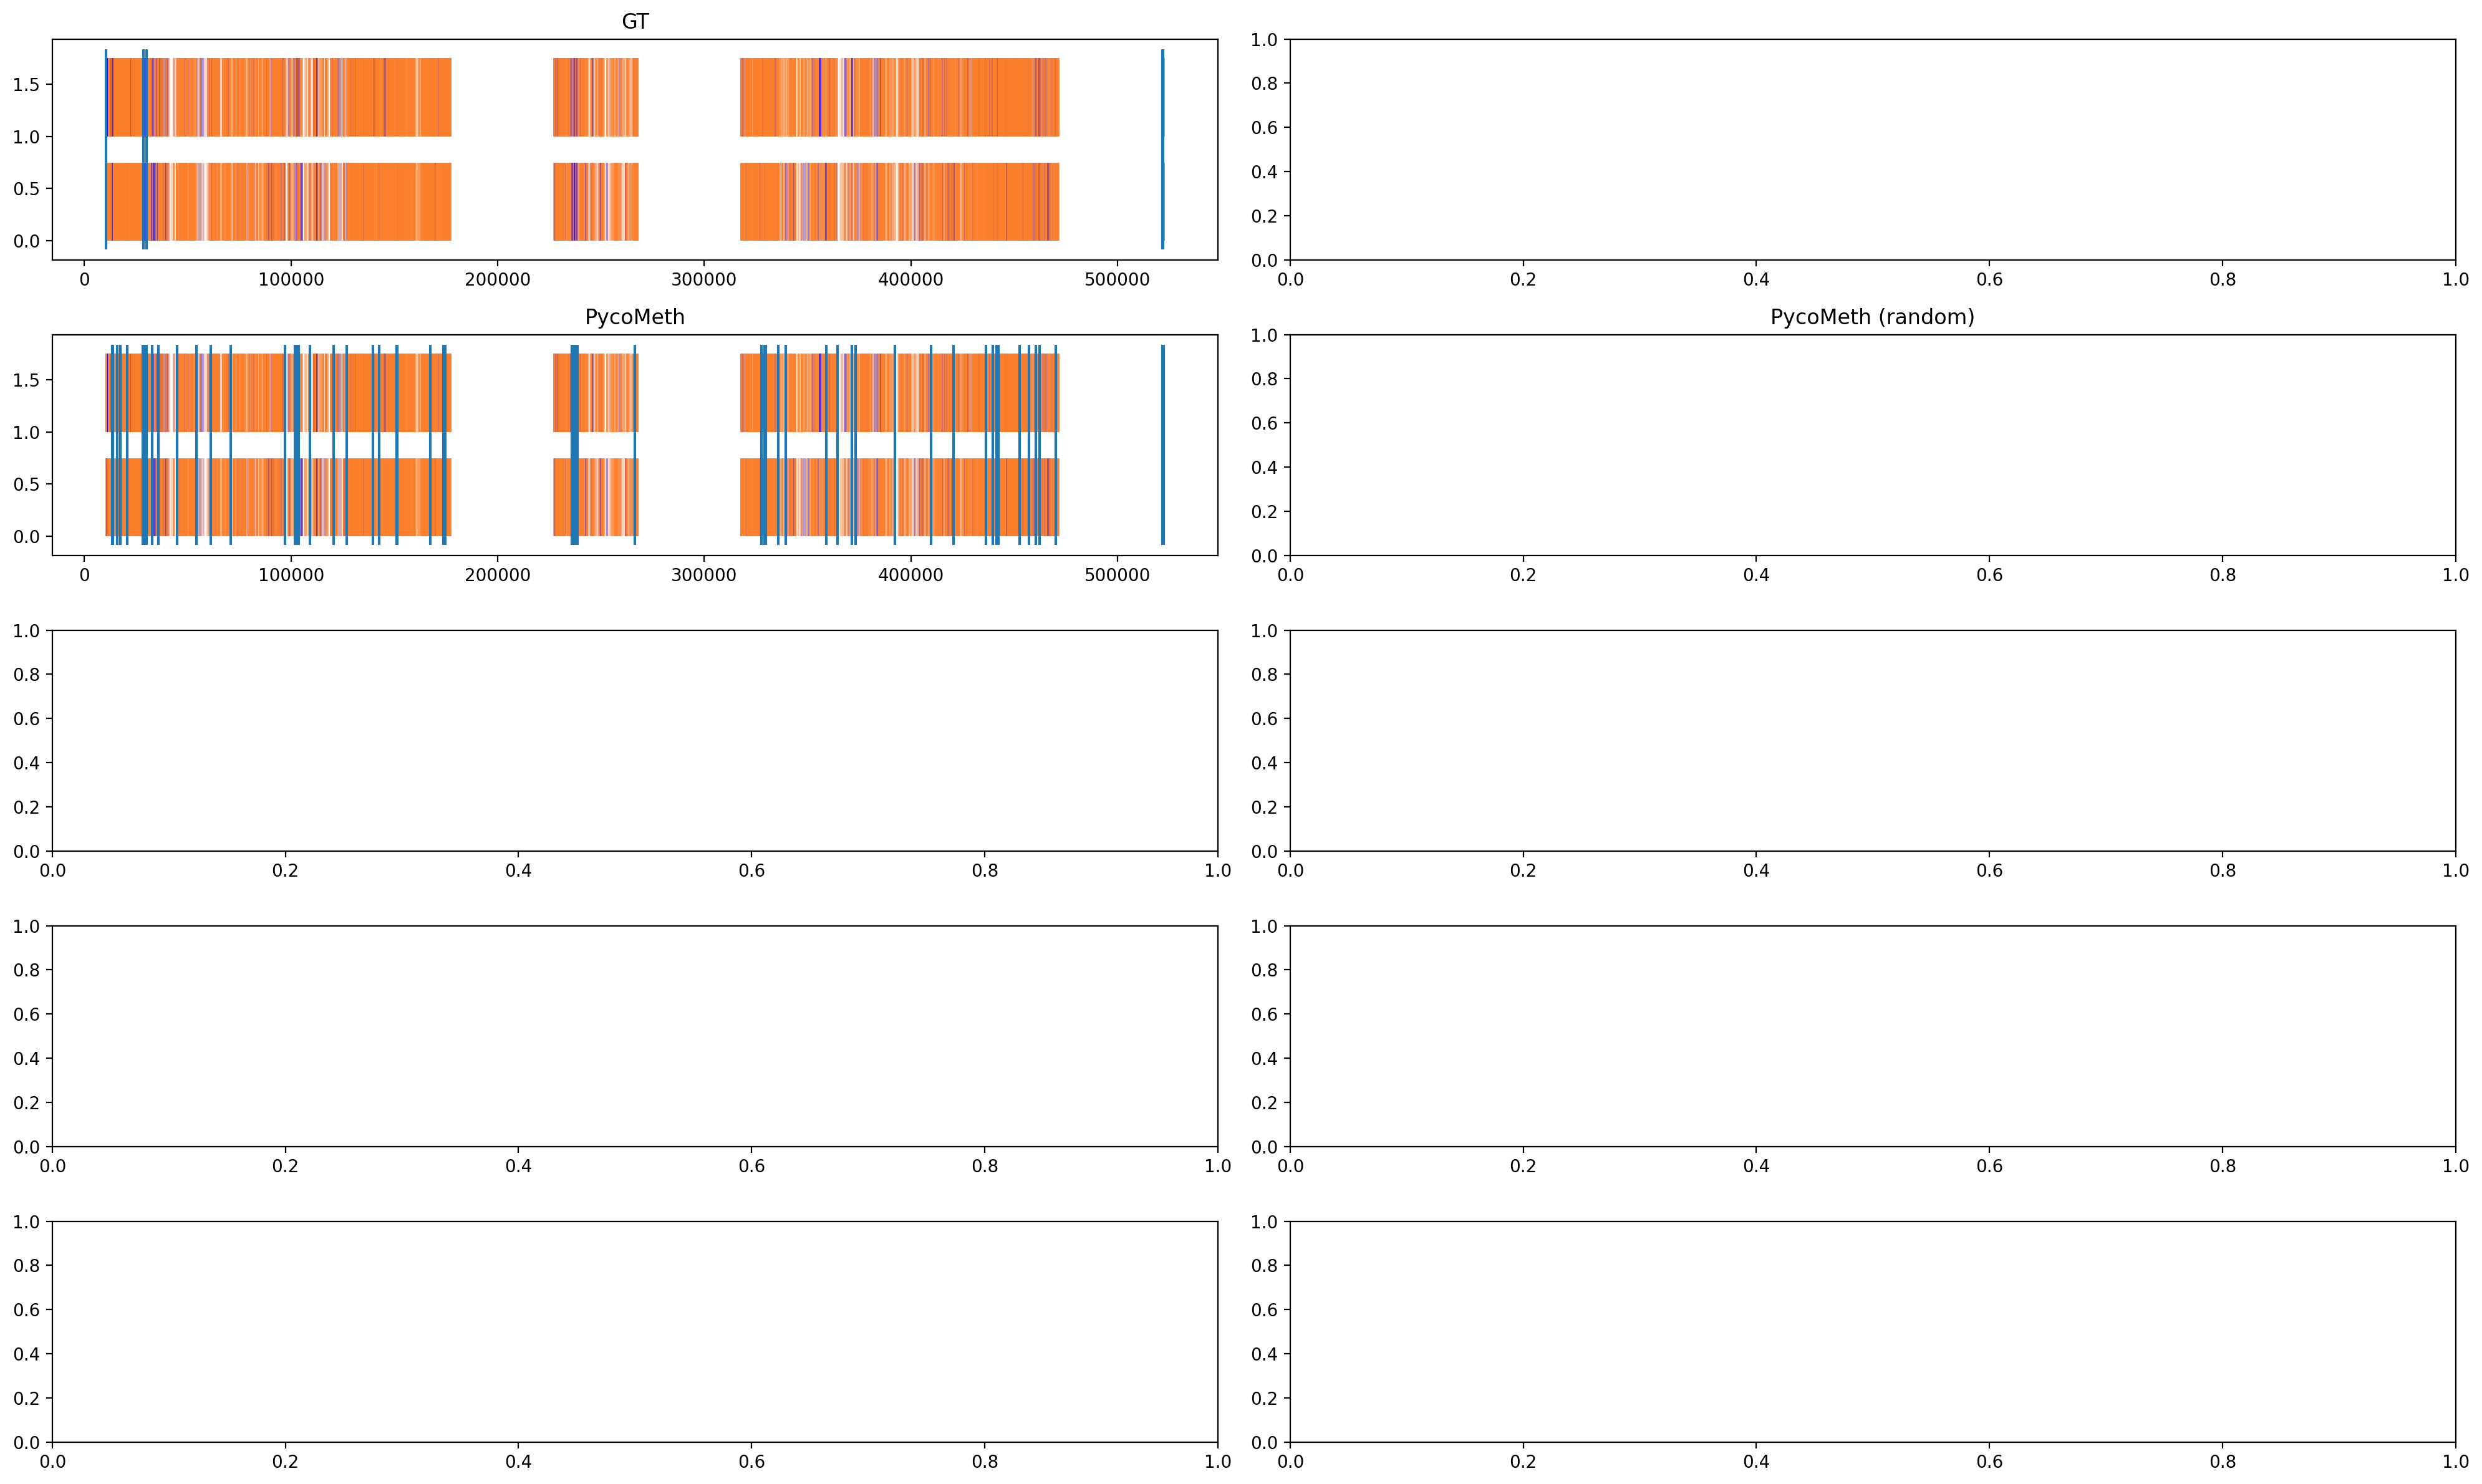

In [32]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(0, len(gt), 5):
        toshow = gt.iloc[i:i+5]
        if all(toshow["theta"] == 0):
            continue
        hightlights = [[r["start"], r["end"]] for r in toshow.iterrows()]
        start, end = toshow.iloc[0]["start"]-500, toshow.iloc[-1]["start"]+500
        print(start, end)
        plot_methylation_all_segments("1", start, end, hightlights=hightlights)

In [328]:
import importlib
import nanoepitools.plotting.plot_methylation_profile
importlib.reload(nanoepitools.plotting.plot_methylation_profile)
plot_met_profile_from_matrix= nanoepitools.plotting.plot_methylation_profile.plot_met_profile_from_matrix

In [74]:
segment_classes = {}
for tool in sc.predicted_segments:
    if "random" in tool:
        continue
    segment_classes[tool] = sc.classify_all_segments(tool)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4419/4419 [01:27<00:00, 50.30it/s]


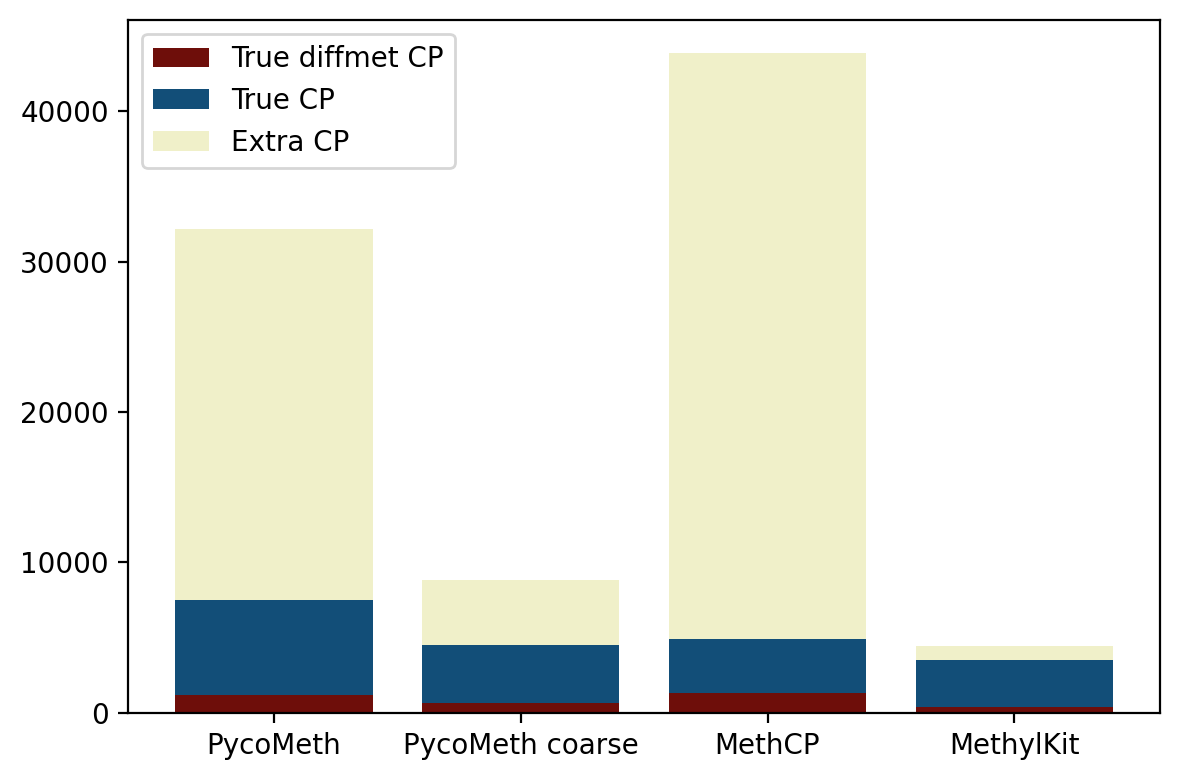

In [177]:
pa.figure()
tools = ["PycoMeth", "PycoMeth coarse", "MethCP", "MethylKit"]
pretty_labels = {"unsupported": "Extra CP", "true_cp": "True CP", "diff_seg_cp": "True diffmet CP"}
label_order = ["diff_seg_cp", "true_cp", "unsupported"]
colors = {"unsupported": "#F0F0C9", "true_cp": "#124E78", "diff_seg_cp": "#6E0E0A"}
bottom = [0 for _ in tools]
for label in label_order:
    h = [segment_classes[tool][label] for tool in tools]
    plt.bar(tools, h, bottom=bottom, label=pretty_labels[label], color=colors[label])
    bottom = [b+hi for b,hi in zip(bottom, h)]
plt.legend()
plt.show()

In [190]:
leftover_segments = {}
for tool in sc.predicted_segments:
    if "random" in tool:
        continue
    leftover_segments[tool] = sc.count_segments_identified(tool)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4419/4419 [01:08<00:00, 64.10it/s]


In [241]:
def count_leftover_segments(leftover, cps_not_used):
    counts = {}
    found = gt.drop(leftover.index)
    counts["Diffmet found"] = (found["theta"] != 0).sum()
    counts["Found"] = (found["theta"] == 0).sum()
    idx_leftover_diffmet = leftover["theta"] != 0
    counts["Diffmet one end"] = leftover.loc[idx_leftover_diffmet]["found_right"].sum() + leftover.loc[idx_leftover_diffmet]["found_left"].sum()
    counts["One end"] = leftover["found_right"].sum() + leftover["found_left"].sum() - counts["Diffmet one end"]

    counts["Diffmet not found"] = idx_leftover_diffmet.sum() - counts["Diffmet one end"]
    counts["Not found"] = (~idx_leftover_diffmet).sum() - counts["One end"]

    counts["Additional CPs"] = 0
    for a, b in zip(tqdm.tqdm(cps_not_used), cps_not_used[1:]):
        # this might be the same changepoint (just end and start merged)
        cgs = reference_cpgs.get_CGs("1", a+1, b-1)
        if len(cgs) > 0:
            counts["Additional CPs"] += 1

    return counts
tool_found_counts = {tool: count_leftover_segments(*leftover_segments[tool]) for tool in leftover_segments}
tool_found_counts["GT"]={"Diffmet found": len(gt_only_diffmet),
                         "Found": len(gt)-len(gt_only_diffmet)}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 6533/6534 [00:36<00:00, 178.36it/s]


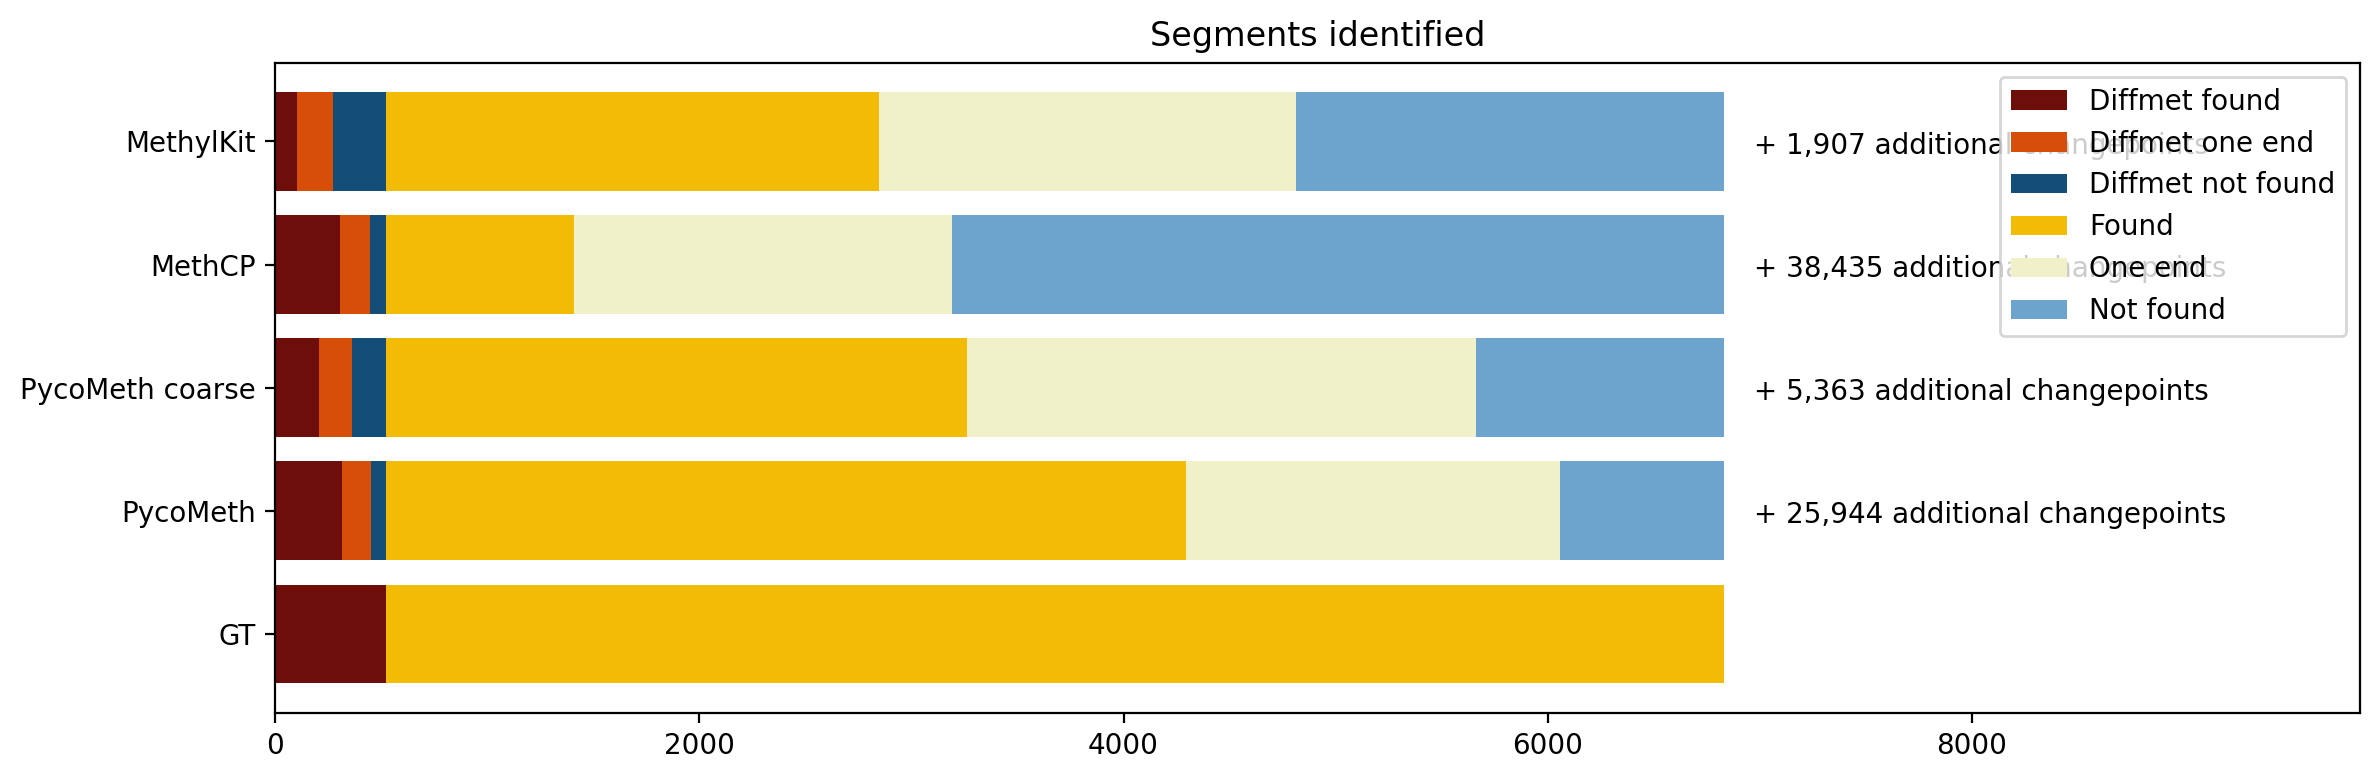

In [253]:
pa.figure(figsize=(12,4))
tools = ["GT", "PycoMeth", "PycoMeth coarse", "MethCP", "MethylKit"]
label_order = ["Diffmet found", "Diffmet one end", "Diffmet not found", "Found", "One end", "Not found"]#, "Additional CPs"]
colors = {"Diffmet found":"#6E0E0A", "Diffmet one end":"#D74E09", "Found":"#F2BB05", "One end":"#F0F0C9", "Diffmet not found":"#124E78", "Not found": "#6da4cd", "Additional CPs": "gray"}
bottom = [0 for _ in tools]
for label in label_order:
    h = [tool_found_counts[tool].get(label, 0) for tool in tools]
    plt.barh(tools, h, left=bottom, label=label, color=colors[label])
    bottom = [b+hi for b,hi in zip(bottom, h)]
xmax = plt.xlim()[1]
plt.xlim(0, xmax+3000)
for i, tool in enumerate(tools):
    if tool == "GT":
        continue
    a_cp = tool_found_counts[tool]["Additional CPs"]
    plt.text(xmax+100, i-0.1, f" + {a_cp:,} additional changepoints")

plt.title("Segments identified")
#plt.ylim(-0.5, len(tools)+1)
plt.legend()
pa.saveandshow("segments_correctly_found")

In [221]:
leftover_segments["PycoMeth (merged)"] = sc.count_segments_identified("PycoMeth (merged)")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7081/7081 [01:48<00:00, 65.56it/s]


In [222]:
tool_found_counts["PycoMeth (merged)"] = count_leftover_segments(*leftover_segments["PycoMeth (merged)"])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 6533/6534 [00:36<00:00, 177.36it/s]
